### Node2Vec Implementation Using networkx

In [1]:
import networkx as nx
from collections import defaultdict
import numpy as np
from gensim.models import Word2Vec
import matplotlib as plt

In [40]:
class MyNode2Vec:
    
    PROBABILITY_NAME = 'probabilities'
    
    def __init__(self,
                 graph: nx.Graph, 
                 embedding_dimension: int = 128, 
                 walk_length: int = 80, 
                 num_walks: int = 10,
                 p: float = 1, 
                 q: float = 1, 
                 weight_key: str = 'weight'):
        self.graph = graph
        self.embedding_dimension = embedding_dimension
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.weight_key = weight_key
        self.walks = list()
        
        # Init dictionary. This dictionary will contain the new probabilities 
        # for each walk from every node in the graph
        self.probabilities = defaultdict(dict)
        for node in graph.nodes():
            self.probabilities[node][self.PROBABILITY_NAME] = dict()

    
    def compute_probabilities(self):
        
        G = self.graph    
            
        #Compute new probabilities using p, q 
        for source_node in G.nodes():
            # source_node = previous node (from current_node point of view)
            for current_node in G.neighbors(source_node):
                probs_current = list()
                for next_node in G.neighbors(current_node):
                    # next_node from current_node point of view
                    if next_node == source_node:
                        # inmediately revisit a node -> w' = w/p
                        prob = G[current_node][next_node].get('weight', 1)*(1/self.p)
                    elif next_node in G.neighbors(source_node):
                        # visit a node that is source_node's neighbor -> w' = w
                        prob = G[current_node][next_node].get('weight', 1)
                    else:
                        # visit a new node -> w' = w/q
                        prob = G[current_node][next_node].get('weight', 1)*(1/self.q)
                    probs_current.append(prob)
                self.probabilities[source_node][self.PROBABILITY_NAME][current_node] = probs_current/np.sum(probs_current)
                
    def node2vec_walk(self, start_node):
        G = self.graph
        walk = [start_node]
        
        next_nodes = list(G[start_node])
        # If start_node does not have any neighbor
        if len(next_nodes) == 0:
            return walk
        
        # First step must be random
        next_node = np.random.choice(next_nodes)
        walk.append(next_node)
        
        previous_node = start_node
        current_node = next_node
        
        # Next steps are obtained using the probabilities already computed
        for i in range(self.walk_length - 2):
            next_next_nodes = list(G[current_node])
            if (len(next_next_nodes) == 0):
                break
            #print(list(map(str, list(walk))))
            next_next_node = np.random.choice(next_next_nodes, 
                                              p=self.probabilities[previous_node][self.PROBABILITY_NAME][current_node])
            walk.append(next_next_node)
            previous_node = current_node
            current_node = next_next_node
        return walk
    
    def random_walks(self):
        G = self.graph
        walks = list()
        
        for start_node in G.nodes():
            for i in range(self.num_walks):
                walk = self.node2vec_walk(start_node)
                walks.append(walk)
        return walks
    
    def embed(self, walks):
        walks2 = [list(map(str, walk)) for walk in walks]
        model = Word2Vec(walks2,size=self.embedding_dimension)
        return model

    def learn_embeddings(self):
        self.compute_probabilities()
        random_walks = self.random_walks()
        model = self.embed(random_walks)
        return model

In [67]:
# Simple Graph (Testing Purposes)
G = nx.DiGraph()
G.add_edge('a', 'b', weight=0.6)
G.add_edge('a', 'c', weight=0.2)
G.add_edge('c', 'd', weight=0.1)
G.add_edge('c', 'e', weight=0.7)
G.add_edge('c', 'f', weight=0.9)
G.add_edge('a', 'd', weight=0.3)

{('a', 'b'): Text(0.7499999888241293, 0.433012741974907, '0.6'),
 ('a', 'c'): Text(0.24999998137354879, 0.4330127121725851, '0.2'),
 ('a', 'd'): Text(1.4901160971803051e-08, -1.9206817775722963e-08, '0.3'),
 ('c', 'd'): Text(-0.7500000037252903, 0.43301266846119746, '0.1'),
 ('c', 'e'): Text(-0.49999996274709757, -5.297752070365647e-09, '0.7'),
 ('c', 'f'): Text(-5.9604643887212205e-08, -5.297752070365647e-09, '0.9')}

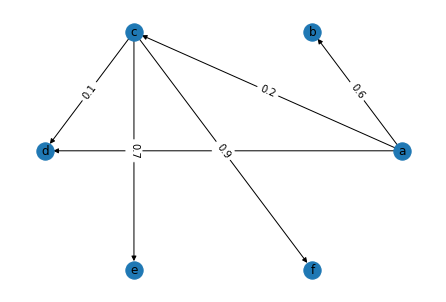

In [68]:
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos, edge_labels=labels)

In [69]:
g_n2v = MyNode2Vec(graph=G, 
               embedding_dimension=2, 
               walk_length=4, 
               num_walks=20, 
               p=2, 
               q=3)
g_model = g_n2v.learn_embeddings()

In [70]:
g_embeddings = g_model.wv[G.nodes()]
g_embeddings

array([[-0.18104707, -0.21838133],
       [-0.02916444,  0.13458848],
       [-0.22574356, -0.06096765],
       [-0.09667541,  0.14186592],
       [ 0.04770864, -0.09987374],
       [ 0.16922715, -0.23851052]], dtype=float32)

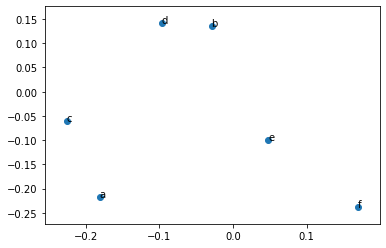

In [71]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots()
x = g_embeddings[:,0]
y = g_embeddings[:,1]
ax.scatter(x, y)

for i, node in enumerate(G.nodes()):
    ax.annotate(node, (x[i], y[i]))

In [111]:
# Let's add two very similar nodes to (b) and test if they appear close to (b)

{('a', 'b'): Text(0.8830222197173554, 0.3213938056005782, '0.6'),
 ('a', 'b1'): Text(0.5868241143768091, 0.4924038814676875, '0.6'),
 ('a', 'c'): Text(0.030153698191684564, -0.17101005599889452, '0.2'),
 ('a', 'd'): Text(0.250000049670537, -0.43301270118678475, '0.3'),
 ('b', 'b1'): Text(0.46984633409416454, 0.8137976672000509, '0.5'),
 ('b1', 'b2'): Text(-0.16317591045845936, 0.9254165727203649, '0.2'),
 ('b3', 'b2'): Text(-0.719846326643584, 0.6040228167903237, '0.2'),
 ('c', 'd'): Text(-0.7198462521377784, -0.6040227770538941, '0.1'),
 ('c', 'e'): Text(-0.38302221723382857, -0.6634139175983672, '0.7'),
 ('c', 'f'): Text(-0.08682414169560437, -0.49240393113822445, '0.9')}

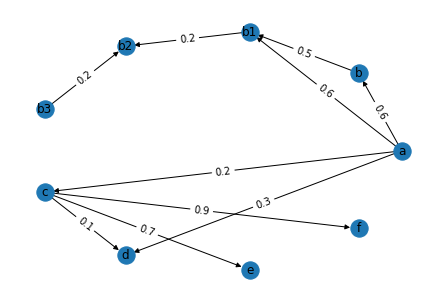

In [84]:
G1 = nx.DiGraph()
G1.add_edge('a', 'b', weight=0.6)
G1.add_edge('b', 'b1', weight=0.5)
G1.add_edge('a', 'b1', weight=0.6)
G1.add_edge('b1', 'b2', weight=0.2)
G1.add_edge('b3', 'b2', weight=0.2)
G1.add_edge('a', 'c', weight=0.2)
G1.add_edge('c', 'd', weight=0.1)
G1.add_edge('c', 'e', weight=0.7)
G1.add_edge('c', 'f', weight=0.9)
G1.add_edge('a', 'd', weight=0.3)
pos = nx.circular_layout(G1)
nx.draw(G1, pos, with_labels=True)
labels = nx.get_edge_attributes(G1,'weight')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=labels)

In [85]:
g1_n2v = MyNode2Vec(graph=G1, 
               embedding_dimension=2, 
               walk_length=4, 
               num_walks=20, 
               p=2, 
               q=3)
g1_model = g1_n2v.learn_embeddings()
g1_embeddings = g1_model.wv[list(map(str, G1.nodes()))]
g1_embeddings

array([[-0.1809994 , -0.21852343],
       [-0.02912717,  0.1345632 ],
       [-0.06830549,  0.09320606],
       [-0.03470355, -0.18581057],
       [ 0.08394176,  0.20490319],
       [-0.2258378 , -0.06108423],
       [-0.09666525,  0.14166313],
       [ 0.04770864, -0.09987374],
       [ 0.16919668, -0.23854867]], dtype=float32)

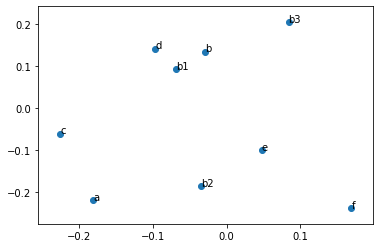

In [86]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots()
x = g1_embeddings[:,0]
y = g1_embeddings[:,1]
ax.scatter(x, y)

for i, node in enumerate(G1.nodes()):
    ax.annotate(node, (x[i], y[i]))

### Karate Club Graph

In [90]:
karate = nx.karate_club_graph()

In [93]:
karate_n2v = MyNode2Vec(graph=karate,
                       embedding_dimension=10,
                       walk_length=40,
                       num_walks=80,
                       p=1,
                       q=1)

In [94]:
karate_model = karate_n2v.learn_embeddings()

In [95]:
karate_embeddings = k_model.wv[list(map(str,karate.nodes()))]

#### Visualize embeddings using T-SNE

In [97]:
from sklearn.manifold import TSNE

In [98]:
karate_tsne_2 = TSNE(n_components=2).fit_transform(karate_embeddings)

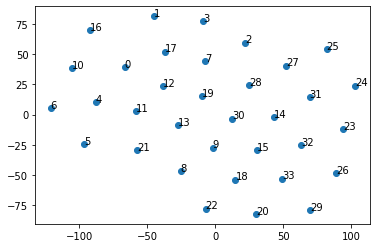

In [99]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots()
x = karate_tsne_2[:,0]
y = karate_tsne_2[:,1]
ax.scatter(x, y)

for i, node in enumerate(karate.nodes()):
    ax.annotate(node, (x[i], y[i]))

Not very interesting, let's try with another graph

In [100]:
import pandas as pd

In [104]:
got_book1 = pd.read_csv("/home/irene/dev/notebooks-jupyter/got_dataset/book1.csv")
got_book1

,Source,Target,Type,weight,book
0,Addam-Marbrand,Jaime-Lannister,Undirected,3,1
1,Addam-Marbrand,Tywin-Lannister,Undirected,6,1
2,Aegon-I-Targaryen,Daenerys-Targaryen,Undirected,5,1
3,Aegon-I-Targaryen,Eddard-Stark,Undirected,4,1
4,Aemon-Targaryen-(Maester-Aemon),Alliser-Thorne,Undirected,4,1
...,...,...,...,...,...
679,Tyrion-Lannister,Willis-Wode,Undirected,4,1
680,Tyrion-Lannister,Yoren,Undirected,10,1
681,Tywin-Lannister,Varys,Undirected,4,1
682,Tywin-Lannister,Walder-Frey,Undirected,8,1


In [106]:
# build graph from interactions (csv)
G_got = nx.Graph()
for _, edge in got_book1.iterrows():
    G_got.add_edge(edge['Source'], edge['Target'], weight=edge['weight'])

In [112]:
got_n2v = MyNode2Vec(graph=G_got,
          embedding_dimension=64,
          walk_length=20,
          num_walks=20,
          p=2,
          q=2)

In [113]:
got_model = got_n2v.learn_embeddings()

In [114]:
got_embeddings = got_model.wv[G_got.nodes()]

In [115]:
got_embeddings

array([[-0.17163128, -0.17865886,  0.29438496, ...,  0.4224231 ,
        -0.28554574,  0.09542911],
       [-0.12622465, -0.61420727,  0.5301714 , ...,  0.6092588 ,
        -0.46481347, -0.02664985],
       [-0.02742191, -0.67279565,  0.50745034, ...,  0.9003287 ,
        -0.51323724, -0.09940763],
       ...,
       [-0.04660253,  0.22940798,  0.05201129, ...,  0.18211578,
        -0.02051175,  0.0275763 ],
       [-0.0865505 , -0.1285313 ,  0.29648402, ...,  0.64758885,
        -0.2974122 ,  0.2352539 ],
       [-0.1869552 , -0.0819085 ,  0.3042849 , ...,  0.61213267,
        -0.3464052 ,  0.29658172]], dtype=float32)

In [116]:
got_tsne = TSNE(n_components=2).fit_transform(got_embeddings)

In [118]:
len(G_got.nodes())

187

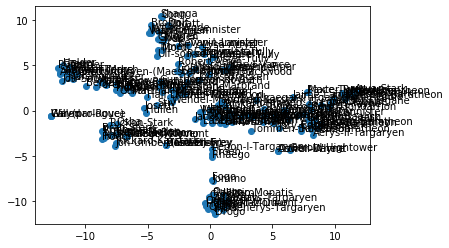

In [117]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots()
x = got_tsne[:,0]
y = got_tsne[:,1]
ax.scatter(x, y)

for i, node in enumerate(G_got.nodes()):
    ax.annotate(node, (x[i], y[i]))

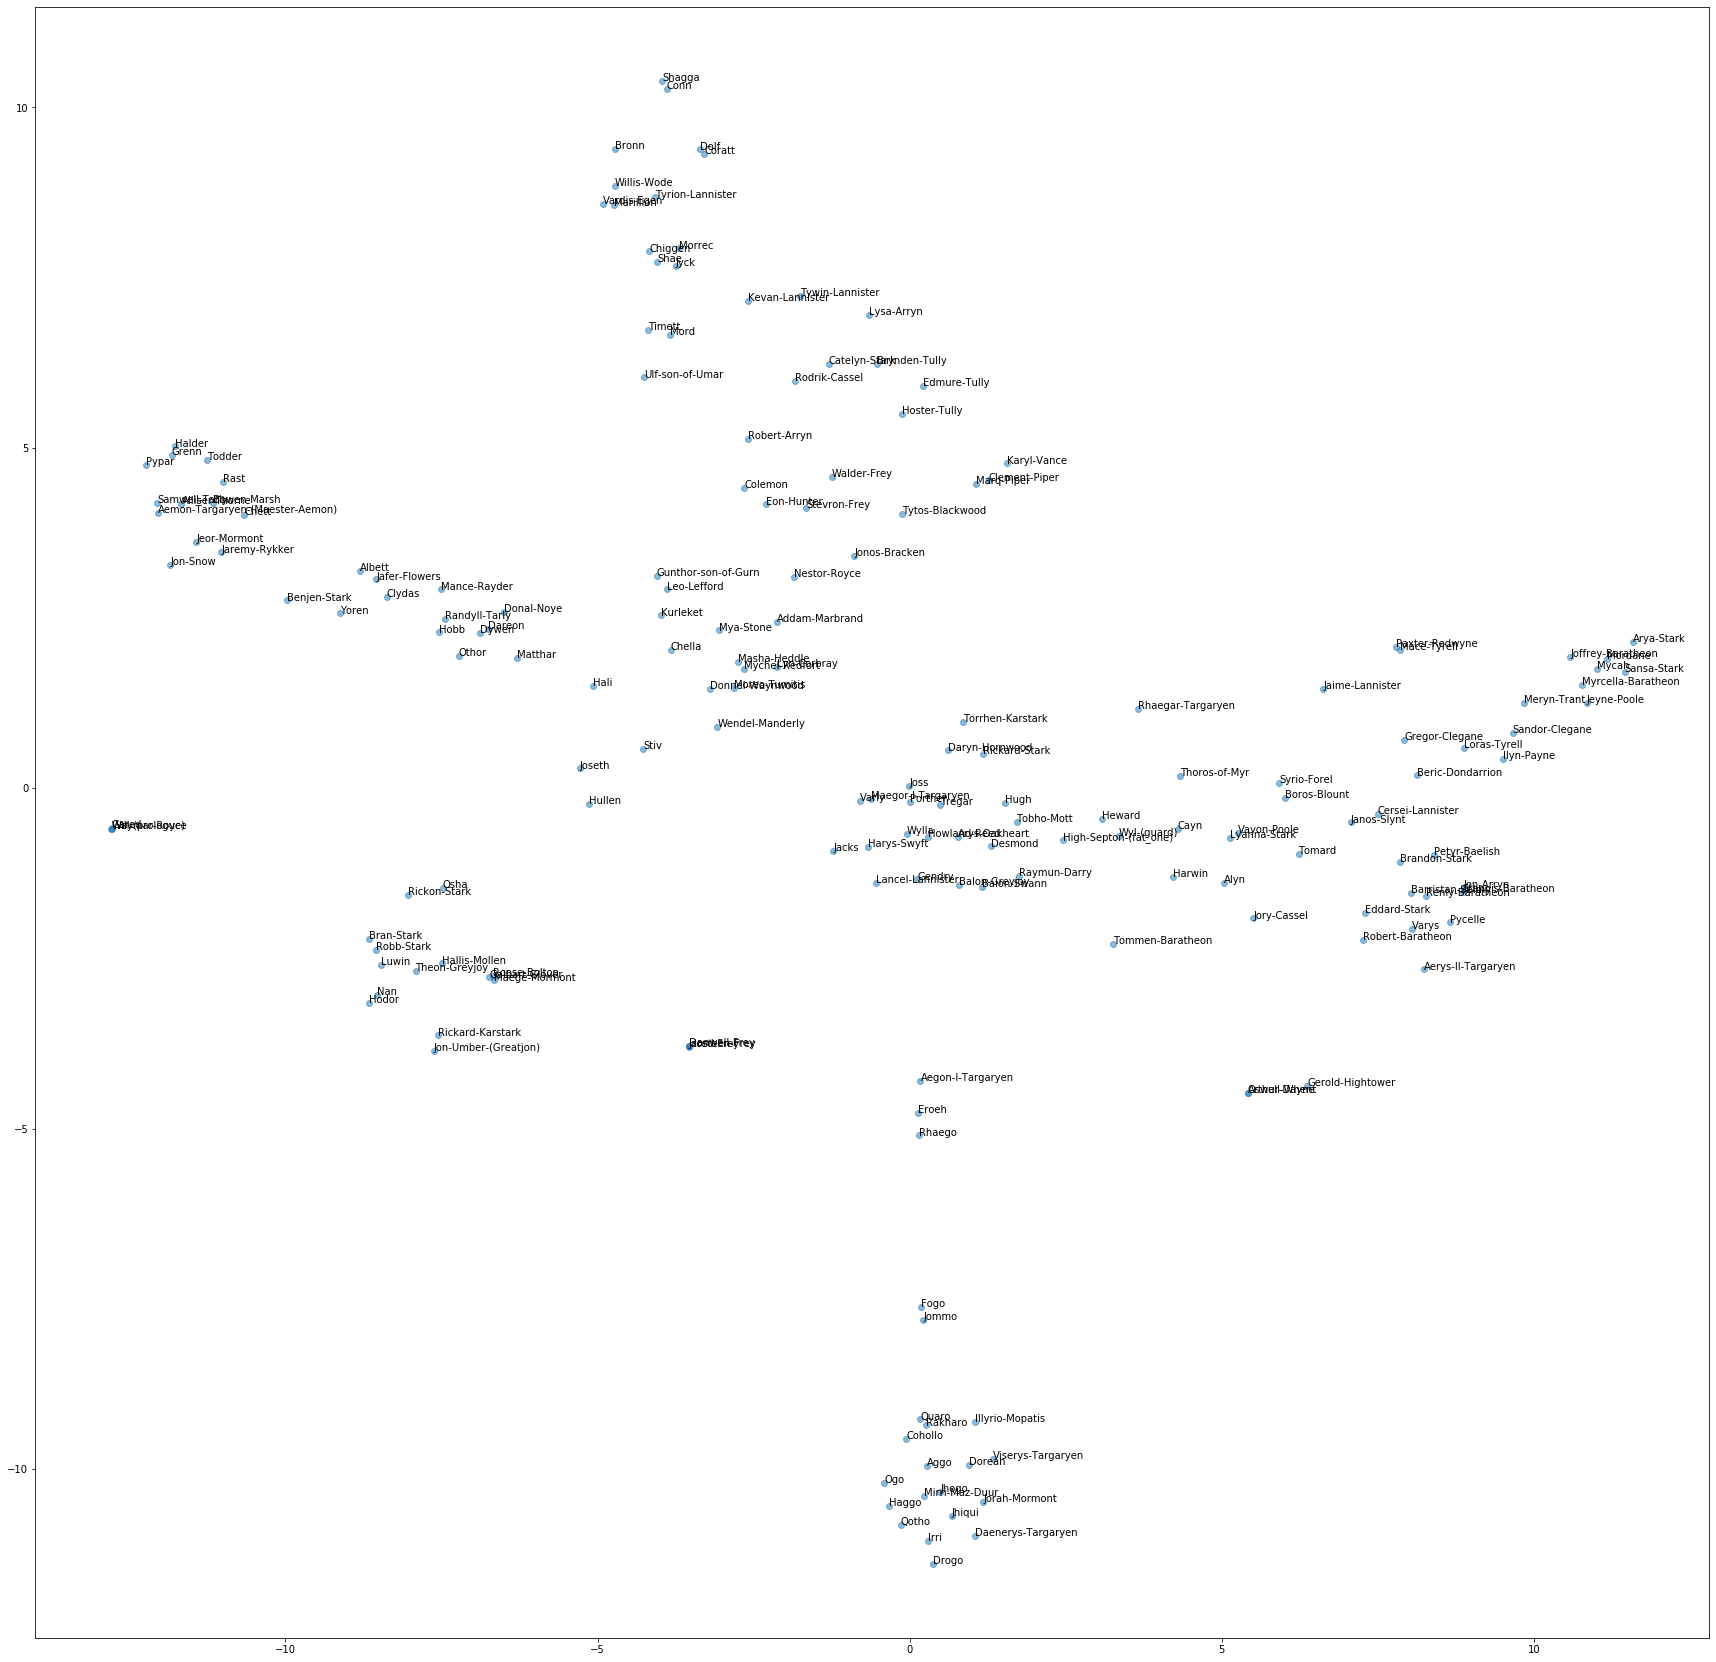

In [128]:
pyplt.figure(figsize=[30, 30])
pyplt.scatter(x, y, alpha=0.5)

for i, node in enumerate(G_got.nodes()):
    pyplt.annotate(node, (x[i], y[i]))